<img src="resources/cropped-SummerWorkshop_Header.png">  

<h1 align="center">Visual Behavior Neuropixels Workshop SWDB 2022 </h1> 
<h3 align="center">Tuesday, August 23rd, 2022</h3> 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<p>This notebook will introduce you to the Visual Behavior Neuropixels dataset and associated AllenSDK functions. 
    
<p>The introduction is centered around a set of scientific questions: 

### How does image novelty impact: 
    
1) <a href='#How-does-novelty-impact-visual-responsiveness?'>Visual responses in visual cortex</a>
* <a href='#Accessing-the-Dataset'>Accessing the Dataset</a>
* <a href='#Filtering-the-sessions-table-for-a-session-of-interest'>Filtering the sessions table for a session of interest</a>
* <a href='#Understanding-the-session-object'>Understanding the session object</a>
* <a href='#Plotting-receptive-fields'>Plotting receptive fields</a>
* <a href='#Plotting-visual-responses-to-novel-and-familiar-images'>Plotting visual responses to novel and familiar images</a>
* <a href='#Using-Optotagging-to-Identify-SST-Neurons'>Using Optotagging to Identify SST Neurons</a>
    
2) <a href='#How-does-novelty-impact-mouse-behavior?'>Behavior during the Detection of Change task
* <a href='#Understanding-the-trials-table'>Understanding the trials table</a>
* <a href='#Calculating-hit-rates-for-novel-and-familiar-images'>Calculating hit rates for novel and familiar images</a>
* <a href='#Getting-pupil,-running-and-licking-data'>Getting pupil, running and licking data</a>
* <a href='#Aligning-behavioral-data-to-task-events'>Aligning behavioral data to task events</a>



In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import scipy.ndimage as ndi

%matplotlib inline

# How does novelty impact visual responsiveness?

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
## Accessing the Dataset
    
<p>To answer our questions, we first need to access the data. The main entry point to the VBN dataset is the `VisualBehaviorNeuropixelsProjectCache` class.  This class is responsible for downloading any requested data or metadata as needed and storing it in well known locations.  For this workshop, all of the data has been preloaded onto the hard drives you have received, and is available on AWS.

<p>We begin by specifying our data cache directory. Then we'll import the `VisualBehaviorNeuropixelsProjectCache` class and instantiate it.

</div>

In [3]:
import platform
platstring = platform.platform()

if 'Darwin' in platstring:
    # macOS 
    data_root = "/Volumes/Brain2022/"
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/"
elif ('amzn1' in platstring):
    # then on AWS
    data_root = "/data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/Brain2022/"

In [2]:
from allensdk.brain_observatory.behavior.behavior_project_cache.\
    behavior_neuropixels_project_cache \
    import VisualBehaviorNeuropixelsProjectCache

C:\Users\svc_ccg\AppData\Local\Continuum\anaconda3\envs\allensdk_38\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# this path should point to the location of the dataset on your platform
cache_dir = r"\\allen\programs\mindscope\workgroups\np-behavior\vbn_data_release\vbn_s3_cache"

cache = VisualBehaviorNeuropixelsProjectCache.from_s3_cache(
            cache_dir=cache_dir)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

The data manifest is comprised of 5 types of tables: 

1. `ecephys_sessions_table` (64 kB)
2. `behavior_sessions_table` (531 kB)
3. `units_table` (130 MB)
4. `probes_table` (127 kB)
5. `channels_table` (28 MB)

The `ecephys_sessions_table` contains metadata for every <b>Neuropixels recording session</b> in the dataset. We attempted to insert 6 probes for each experiment, but occasionally individual insertions failed. The `probe_count` column tells you how many probes were inserted for a given session. The `structure_acronyms` column indicates which brain areas were targeted. For the majority of mice, there are two recording sessions. These were run on consecutive days with two different image sets, `G` and `H`. The `experience_level` column tells you whether the image set used for a particular recording was the same as the training image set (`Familiar`), or different from the training image set (`Novel`).

The `behavior_sessions_table` contains metadata for each behavior session. Some behavior sessions have Neuropixels data associated with them, while others took place during training in the behavior facility. The different training stages that mice progressed through are described by the `session_type`. 

The `units_table` contains metadata for every unit in the release. Each unit can be linked to the corresponding recording session, probe and channel by the `ecephys_session_id`, `ecephys_probe_id` and `ecephys_channel_id` columns. This table also contains a number of helpful quality metrics, which can be used to filter out contaminated units before analysis. For more guidance on how to use these metrics, check out [this tutorial](https://allensdk.readthedocs.io/en/latest/_static/examples/nb/visual_behavior_neuropixels_quality_metrics.html).

The `probes_table` contains metadata for each probe insertion.

The `channels_table` contains metadata for each channel recorded during an ephys session. This table provides useful info about where a particular channel is located in the Allen Common Coordinate Framework as well as it's relative position on the probe.

Now let's look at a few of these tables in more detail to get a better sense of the dataset.
    
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
## Filtering the sessions table for a session of interest
    
<p>Now let's grab the sessions table from the cache and take a look at what information it provides.

</div>

In [4]:
ecephys_sessions_table = cache.get_ecephys_session_table()
ecephys_sessions_table.head()

,behavior_session_id,date_of_acquisition,equipment_name,session_type,mouse_id,genotype,sex,project_code,age_in_days,unit_count,...,channel_count,structure_acronyms,image_set,prior_exposures_to_image_set,session_number,experience_level,prior_exposures_to_omissions,file_id,abnormal_histology,abnormal_activity
ecephys_session_id,,,,,,,,,,,,,,,,,,,,,
1052342277,1052374521,2020-09-23 15:34:18.179,NP.1,EPHYS_1_images_G_3uL_reward,530862,Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,M,NeuropixelVisualBehavior,148,1696.0,...,2304.0,"['APN', 'CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg...",G,32.0,1,Familiar,0.0,0,NaN,NaN
1051155866,1052162536,2020-09-17 15:05:39.665,NP.1,EPHYS_1_images_H_3uL_reward,524760,wt/wt,F,NeuropixelVisualBehavior,180,1922.0,...,2304.0,"['APN', 'CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg...",H,0.0,2,Novel,1.0,1,NaN,NaN
1052533639,1052572359,2020-09-24 15:12:13.229,NP.1,EPHYS_1_images_H_3uL_reward,530862,Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,M,NeuropixelVisualBehavior,149,1677.0,...,2304.0,"['APN', 'CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg...",H,0.0,2,Novel,1.0,4,NaN,NaN
1053925378,1053960984,2020-10-01 16:07:18.990,NP.0,EPHYS_1_images_H_3uL_reward,532246,Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,M,NeuropixelVisualBehavior,145,1823.0,...,2304.0,"['APN', 'CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg...",H,0.0,2,Novel,1.0,5,NaN,NaN
1053941483,1053960987,2020-10-01 17:03:58.362,NP.1,EPHYS_1_images_H_3uL_reward,527749,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,M,NeuropixelVisualBehavior,180,1543.0,...,2304.0,"['APN', 'CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg...",H,0.0,2,Novel,1.0,6,NaN,NaN


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

This table gives us lots of useful metadata about each recording session, including when the session took place, the genotype, sex and age of the mouse that was run, what brain areas were recorded and some important info about the stimulus. 

To demystify a few of these columns, let's briefly review the experimental design. Each mouse was trained with one of two image sets (`G` or `H`). For the majority of mice, we recorded two sessions: one with the trained `familiar` image set and one with a `novel` image set. Note that two of the eight images were shared across these two image sets as diagrammed below for an example mouse that was trained with image set `G`. 
    
</div>

<div>
<img src="https://brainmapportal-live-4cc80a57cd6e400d854-f7fdcae.divio-media.net/filer_public/38/65/3865999b-e8c4-4b2d-bead-2bb385448a8d/gh_diagram.png", width="900"/>
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

So, each recording session can be defined by a few parameters, including the `image_set` used (`G` or `H`), the `experience_level` of the mouse (indicating whether the mouse had seen the image set in previous training sessions) and the `session_number` (indicating whether it was the first or second recording day for the mouse). Let's look at how many sessions we have of each type:

</div>

In [5]:
sessions_by_imageset_experience_day = ecephys_sessions_table.pivot_table(index=['session_number', 'experience_level'], #rows of our pivot table
                                                                         columns=['image_set'], #columns of pivot table                                                                         
                                                                         values='behavior_session_id', #column of dataframe to run aggfunc on
                                                                         aggfunc=len) #function to apply to 'values' to fill out pivot table

display(sessions_by_imageset_experience_day)

image_set                           G     H
session_number experience_level            
1              Familiar          38.0  10.0
               Novel              NaN   3.0
2              Familiar           3.0   NaN
               Novel             10.0  39.0

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

In addition to different types of image sets, this dataset contains ephys recording sessions from 3 genotypes (C57BL6J, VIP-IRES-CrexAi32 and SST-IRES-CrexAi32). 

To answer our questions, we need to select a session with:
- `Novel` images presented
- `Sst-IRES-Cre` mouse
    
</div>

In [6]:
sst_novel_sessions = ecephys_sessions_table.loc[(ecephys_sessions_table['genotype'].str.contains('Sst')) & 
                                            (ecephys_sessions_table['experience_level']=='Novel')]
sst_novel_sessions.head()

,behavior_session_id,date_of_acquisition,equipment_name,session_type,mouse_id,genotype,sex,project_code,age_in_days,unit_count,...,channel_count,structure_acronyms,image_set,prior_exposures_to_image_set,session_number,experience_level,prior_exposures_to_omissions,file_id,abnormal_histology,abnormal_activity
ecephys_session_id,,,,,,,,,,,,,,,,,,,,,
1053941483,1053960987,2020-10-01 17:03:58.362,NP.1,EPHYS_1_images_H_3uL_reward,527749,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,M,NeuropixelVisualBehavior,180,1543.0,...,2304.0,"['APN', 'CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg...",H,0.0,2,Novel,1.0,6,NaN,NaN
1064644573,1064666428,2020-11-19 15:18:01.372,NP.1,EPHYS_1_images_H_3uL_reward,544456,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,M,NeuropixelVisualBehavior,120,2254.0,...,2304.0,"['APN', 'CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg...",H,0.0,2,Novel,1.0,27,NaN,NaN
1048189115,1048221709,2020-09-03 14:16:57.913,NP.1,EPHYS_1_images_H_3uL_reward,509808,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,M,NeuropixelVisualBehavior,264,1925.0,...,2304.0,"['APN', 'CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg...",H,0.0,2,Novel,1.0,37,NaN,NaN
1048196054,1048222325,2020-09-03 14:25:07.290,NP.0,EPHYS_1_images_H_3uL_reward,524925,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,F,NeuropixelVisualBehavior,166,2288.0,...,2304.0,"['APN', 'CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg...",H,0.0,2,Novel,1.0,38,NaN,NaN
1065905010,1065929713,2020-11-24 14:21:48.847,NP.0,EPHYS_1_images_H_3uL_reward,544358,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,F,NeuropixelVisualBehavior,126,1998.0,...,2304.0,"['APN', 'CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg...",H,0.0,2,Novel,1.0,39,NaN,NaN


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

## Understanding the session object

All data from a particular recording session is contained in the `ecephys_session` object. Let's load one of our novel, SST sesssions:
    
</div>

In [7]:
session_id = sst_novel_sessions.index.values[0]
session = cache.get_ecephys_session(
            ecephys_session_id=session_id)

C:\Users\svc_ccg\AppData\Local\Continuum\anaconda3\envs\allensdk_38\lib\site-packages\hdmf\utils.py:577: FutureWarning: DynamicTable.__init__: Using positional arguments for this method is discouraged and will be deprecated in a future major release. Please use keyword arguments to ensure future compatibility.
  warnings.warn(msg, FutureWarning)


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

We can get a high-level summary of this session by accessing its `metadata` attribute:
    
</div>

In [8]:
session.metadata

{'equipment_name': 'NP.1',
 'sex': 'M',
 'age_in_days': 180,
 'stimulus_frame_rate': 60.0,
 'session_type': 'EPHYS_1_images_H_3uL_reward',
 'date_of_acquisition': datetime.datetime(2020, 10, 2, 0, 3, 58, tzinfo=tzutc()),
 'reporter_line': 'Ai32(RCL-ChR2(H134R)_EYFP)',
 'cre_line': 'Sst-IRES-Cre',
 'behavior_session_uuid': None,
 'driver_line': ['Sst-IRES-Cre'],
 'mouse_id': 527749,
 'full_genotype': 'Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt',
 'behavior_session_id': 1053960987,
 'ecephys_session_id': 1053941483}

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

### Stimulus presentations

The first step to analyzing how the mouse and its neurons responded to various stimuli is to understand which stimuli were presented at what time. For this, we use the stimulus presentations table.

Every recording session consisted of three major visual stimulus epochs in the following order (diagrammed below):
- An active behavior session during which the mouse performed the change detection task
- Receptive field mapping and full-field flash stimuli
- 'Passive' replay of stimulus shown during active behavior, but without the lickspout so the mouse can no longer respond.
    
</div>

<div>
<img src="https://brainmapportal-live-4cc80a57cd6e400d854-f7fdcae.divio-media.net/filer_public_thumbnails/filer_public/65/58/6558f0eb-c3c5-45e6-b645-b2e432200804/active_passive_diagram.png__710x291_q90_subsampling-2.png", width="900"/>
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Let's look at the stimulus presentations table for the session we already loaded
    
</div>

In [9]:
stimulus_presentations = session.stimulus_presentations
stimulus_presentations.head()

,active,color,contrast,duration,end_frame,flashes_since_change,image_name,is_change,omitted,orientation,...,position_y,rewarded,spatial_frequency,start_frame,start_time,stimulus_block,stimulus_index,stimulus_name,stop_time,temporal_frequency
stimulus_presentations_id,,,,,,,,,,,,,,,,,,,,,
0,True,NaN,NaN,0.250212,75,0.0,im104_r,False,False,NaN,...,NaN,False,NaN,60,25.254420,0,NaN,Natural_Images_Lum_Matched_set_ophys_H_2019,25.504632,NaN
1,True,NaN,NaN,0.250212,120,1.0,im104_r,False,False,NaN,...,NaN,False,NaN,105,26.005057,0,NaN,Natural_Images_Lum_Matched_set_ophys_H_2019,26.255269,NaN
2,True,NaN,NaN,0.250208,165,2.0,im104_r,False,False,NaN,...,NaN,False,NaN,150,26.755685,0,NaN,Natural_Images_Lum_Matched_set_ophys_H_2019,27.005892,NaN
3,True,NaN,NaN,0.250207,210,3.0,im104_r,False,False,NaN,...,NaN,False,NaN,195,27.506307,0,NaN,Natural_Images_Lum_Matched_set_ophys_H_2019,27.756515,NaN
4,True,NaN,NaN,0.250213,255,4.0,im104_r,False,False,NaN,...,NaN,False,NaN,240,28.256929,0,NaN,Natural_Images_Lum_Matched_set_ophys_H_2019,28.507142,NaN


This table is a record of every stimulus we presented to the mouse over the course of this experiment. The different stimuli are indexed by the 'stimulus_block' column. Let's group this dataframe by stimulus block and see what stimulus was shown for each block.

In [10]:
stimulus_presentations.groupby('stimulus_block')[['stimulus_block', 'stimulus_name', 'active', 'duration']].head(1)

,stimulus_block,stimulus_name,active,duration
stimulus_presentations_id,,,,
0,0,Natural_Images_Lum_Matched_set_ophys_H_2019,True,0.250212
4804,1,spontaneous,False,10.008400
4805,2,gabor_20_deg_250ms,False,0.250213
8450,3,spontaneous,False,288.991867
8451,4,flash_250ms,False,0.250213
8601,5,Natural_Images_Lum_Matched_set_ophys_H_2019,False,0.250201


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

This shows us the structure of this experiment (and every experiment in this dataset). There are 5 stimuli as follows:

**block 0**: Change detection task. Natural images are flashed repeatedly and the mouse is rewarded for licking when the identity of the image changes. You can find more info about this task [here](http://portal.brain-map.org/explore/circuits/visual-behavior-neuropixels?edit&language=en).

**block 1**: Brief gray screen

**block 2**: Receptive field mapping. Gabor stimuli used for receptive field mapping. For more details on this stimulus consult [this notebook](https://allensdk.readthedocs.io/en/latest/_static/examples/nb/ecephys_receptive_fields.html).

**block 3**: Longer gray screen

**block 4**: Full-field flashes, shown at 80% contrast. Flashes can be black (color = -1) or white (color = 1).

**block 5**: Passive replay. Frame-for-frame replay of the stimulus shown during the change detection task (block 0), but now with the lick spout retracted so the animal can no longer engage in the task.

    
For now, we will focus on block 0 and 5, the active behavior and the passive replay of the same images.

Let's confirm that the active behavior block (0) and the passive replay block (5) match frame for frame:
</div>

In [11]:
active_image_presentations = stimulus_presentations[stimulus_presentations['stimulus_block']==0]
passive_image_presentations = stimulus_presentations[stimulus_presentations['stimulus_block']==5]
np.all(active_image_presentations['image_name'].values == passive_image_presentations['image_name'].values)

True

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

### Units and channels tables

We'll use the units and channels tables to get info about each unit recorded during the session. These tables will help us filter the data for units in a particular brain region or for units that meet specific quality criteria.
    
</div>

### Units table

In [12]:
units = session.get_units()
units.head()

,PT_ratio,amplitude,amplitude_cutoff,cluster_id,cumulative_drift,d_prime,firing_rate,isi_violations,isolation_distance,l_ratio,...,presence_ratio,quality,recovery_slope,repolarization_slope,silhouette_score,snr,spread,velocity_above,velocity_below,waveform_duration
id,,,,,,,,,,,,,,,,,,,,,
1061853767,0.738222,632.394165,0.000008,23,79.63,10.843623,68.687706,0.000167,246.203332,3.104812e-08,...,0.99,good,-0.808696,2.795432,0.113092,4.519657,60.0,0.686767,0.137353,0.206030
1061853941,0.490965,207.990510,0.273518,196,347.89,3.966892,1.747814,0.374140,60.672055,3.726235e-03,...,0.99,good,-0.112609,0.618665,0.099188,2.541619,70.0,0.480737,0.206030,0.618090
1061853761,0.538560,284.645010,0.475406,17,188.14,4.841153,5.819598,0.010472,74.209946,8.290955e-04,...,0.99,good,-0.312478,1.265120,0.093662,2.558605,60.0,0.343384,-1.098827,0.233501
1061853892,2.714716,180.353940,0.500000,147,1289.78,6.065760,2.396936,0.157757,88.232357,5.768766e-04,...,0.99,good,-0.066549,0.654593,0.051338,2.419777,40.0,-0.343384,-0.686767,0.425796
1061853891,1.105938,533.637585,0.000136,146,474.71,8.037788,2.563054,0.000000,147.532935,7.581718e-08,...,0.99,good,-1.241809,1.728842,0.159304,5.942894,50.0,-0.068677,0.686767,0.151089


### Channels Table

In [13]:
channels = session.get_channels()
channels.head(3)

,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,filtering,left_right_ccf_coordinate,probe_channel_number,probe_horizontal_position,probe_id,probe_vertical_position,structure_acronym
id,,,,,,,,,
1061851368,8315.0,4024.0,AP band: 500 Hz high-pass; LFP band: 1000 Hz l...,6882.0,0,43,1054059289,20,APN
1061851369,8313.0,4014.0,AP band: 500 Hz high-pass; LFP band: 1000 Hz l...,6886.0,1,11,1054059289,20,APN
1061851370,8311.0,4004.0,AP band: 500 Hz high-pass; LFP band: 1000 Hz l...,6889.0,2,59,1054059289,40,APN


Because we will want to use info from both tables to filter our units, we can merge them into one table with all of the relevant columns. This merged table will include quality metrics and CCF locations for every unit. For example, we can use it to see which brain regions were recorded during this session:

In [14]:
units = units.merge(channels, left_on='peak_channel_id', right_index=True)
units.value_counts('structure_acronym')

structure_acronym
CA1      269
APN      170
VISpm    135
POL      109
VISal     84
LP        75
VISp      75
VISrl     74
DG        72
MGv       70
VISl      69
CA3       67
VISam     60
SUB       34
LGv       34
ZI        30
PIL       27
MRN       25
MB        21
TH        13
MGm        8
MGd        8
PoT        6
SGN        5
DT         3
dtype: int64

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

For more information about many of the metrics included in this table and how to use them to guide your analysis, see our [quality metrics tutorial](https://allensdk--2471.org.readthedocs.build/en/2471/_static/examples/nb/visual_behavior_neuropixels_quality_metrics.html). For now, here's a brief description of each column:


**General Metadata**  

`anterior_posterior_ccf_coordinate`:    CCF coord in the AP axis  
`dorsal_ventral_ccf_coordinate`:        CCF coord in the DV axis
`left_right_ccf_coordinate`:            CCF coord in the left/right axis  
`structure_acronym`:                    CCF acronym for area to which unit was assigned  
`structure_id`:                         CCF structure ID for the area to which unit was assigned  
`probe_horizontal_position`:            Horizontal (perpindicular to shank) probe position of each unit's peak channel in microns  
`probe_vertical_position`:              Vertical (along shank) probe position of each unit's peak channel in microns


**Waveform metrics**: Look [here](https://github.com/AllenInstitute/ecephys_spike_sorting/tree/master/ecephys_spike_sorting/modules/mean_waveforms) for more detail on these metrics and the code that computes them. For the below descriptions the '1D waveform' is defined as the waveform on the peak channel. The '2D waveform' is the waveform across channels centered on the peak channel.

`amplitude`:                            Peak to trough amplitude for mean 1D waveform in microvolts   
`waveform_duration`:                    Time from trough to peak for 1D waveform in milliseconds     
`waveform_halfwidth`:                   Width of 1D waveform at half-amplitude in milliseconds  
`PT_ratio`:                             Ratio of the max (peak) to the min (trough) amplitudes for 1D waveform  
`recovery_slope`:                       Slope of recovery of 1D waveform to baseline after repolarization (coming down from peak)  
`repolarization_slope`:                 Slope of repolarization of 1D waveform to baseline after trough  
`spread`:                               Range of channels for which the spike amplitude was above 12% of the peak channel amplitude  
`velocity_above`:                       Slope of spike propagation velocity traveling in dorsal direction from soma (note to avoid infinite values, this is actaully the inverse of velocity: ms/mm)  
`velocity_below`:                       Slope of spike propagation velocity traveling in ventral direction from soma (note to avoid infinite values, this is actually the inverse of velocity: ms/mm)  
`snr`:                                  signal-to-noise ratio for 1D waveform        


**Quality metrics**: Look [here](https://github.com/AllenInstitute/ecephys_spike_sorting/tree/7e567a6fc3fd2fc0eedef750b83b8b8a0d469544/ecephys_spike_sorting/modules/quality_metrics) for more detail on these metrics and the code that computes them.

`amplitude_cutoff`:                     estimate of miss rate based on amplitude histogram (ie fraction of spikes estimated to have been below detection threshold)  
`cumulative_drift`:                     cumulative change in spike depth along probe throughout the recording  
`d_prime`:                              classification accuracy based on LDA  
`firing_rate`:                          Mean firing rate over entire recording  
`isi_violations`:                       Ratio of refractory violation rate to total spike rate  
`isolation_distance`:                   Distance to nearest cluster in Mahalanobis space   
`l_ratio`:                              The Mahalanobis distance and chi-squared inverse cdf are used to find the probability of cluster membership for each spike.  
`max_drift`:                            Maximum change in unit depth across recording  
`nn_hit_rate`:                          Fraction of nearest neighbors in PCA space for spikes in unit cluster that are also in unit cluster  
`nn_miss_rate`:                         Fraction of nearest neighbors for spikes outside unit cluster than are in unit cluster  
`presence_ratio`:                       Fraction of time during session for which a unit was spiking  
`silhouette_score`:                     Standard metric for cluster overlap, computed in PCA space    
`quality`:                              Label assigned based on waveform shape as described [here](https://github.com/AllenInstitute/ecephys_spike_sorting/tree/7e567a6fc3fd2fc0eedef750b83b8b8a0d469544/ecephys_spike_sorting/modules/noise_templates). Either 'good' for physiological waveforms or 'noise' for artifactual waveforms.

    
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

## Plotting receptive fields

Now that we have our units_channel table, let's use it to plot receptive fields for V1. First we'll construct a quality metrics criterion to filter out bad units. Then we'll make an area filter to grab neurons in V1 (or 'VISp' in CCF lingo).
    
</div>

In [15]:
#first let's sort our units by depth
units = units.sort_values('probe_vertical_position', ascending=False)

#now we'll filter them for good units
good_unit_filter = ((units['snr']>1)&             
                    (units['isi_violations']<1)& 
                    (units['firing_rate']>0.1)&   
                    (units['quality']=='good'))  

#let's also filter on structure to pull out V1 neurons
area_filter = (units.structure_acronym == 'VISp')

Now let's apply these filters to select our units:

In [16]:
area_units = units[good_unit_filter & area_filter]

We'll also need the spike times from this experiment:

In [17]:
spike_times = session.spike_times

Finally, we need to get the stimulus info for the gabor stimulus we use to map receptive fields. We can filter the `stimulus_presentations` table for gabor stimuli (note: we could also filter for `stimulus_block` == 2 to get the same data):

In [18]:
rf_stim_table = stimulus_presentations[stimulus_presentations['stimulus_name'].str.contains('gabor')]
xs = np.sort(rf_stim_table.position_x.unique()) #positions of gabor along azimuth
ys = np.sort(rf_stim_table.position_y.unique()) #positions of gabor along elevation

In [146]:
from receptive_field_mapping import ReceptiveFieldMapping_VBN

rf = ReceptiveFieldMapping_VBN(session, filter={'structure_acronym':'VISp'})
rf_metrics = rf.metrics

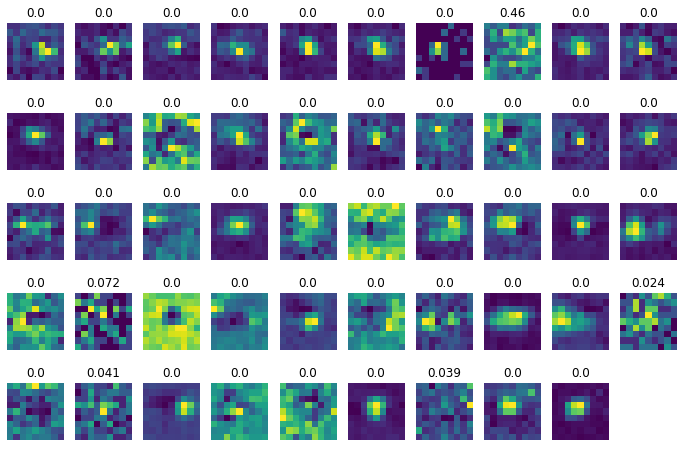

In [151]:
fig, axes = plt.subplots(int(len(area_units)/10)+1, 10)
fig.set_size_inches(12, 8)
for uind, uid in enumerate(area_units.index.values):
    unitrf = rf.get_receptive_field(uid)
    pval = rf_metrics.loc[uid]['p_value_rf']
    ax_row = int(uind/10)
    ax_col = uind%10
    axes[ax_row][ax_col].imshow(unitrf)
    axes[ax_row][ax_col].set_title(pval)
                         
for ax in axes.flat:
    ax.axis('off')

In [ ]:
#Convenience function to compute the PSTH
def makePSTH(spikes, startTimes, windowDur, binSize=0.001):
    bins = np.arange(0,windowDur+binSize,binSize)
    counts = np.zeros(bins.size-1)
    for i,start in enumerate(startTimes):
        startInd = np.searchsorted(spikes, start)
        endInd = np.searchsorted(spikes, start+windowDur)
        counts = counts + np.histogram(spikes[startInd:endInd]-start, bins)[0]
    
    counts = counts/len(startTimes)
    return counts/binSize, bins

For this (and other) analyses, organizing the data into a 3D tensor can make things much more convenient. This tensor will have shape (neurons, trial time, trials) and will store the spike counts for every neuron and trial:


<img src="resources/tensor_diagram.png"
     width="400" 
     height="500" />
     
Williams et al. (2018). Neuron, 98(6): 1099-1115

In [691]:
def make_neuron_time_trials_tensor(units, stim_table, 
                                   time_before, trial_duration,
                                   bin_size=0.001):
    '''
    Function to make a tensor with dimensions [neurons, time, trials] to store
    the spike counts for stimulus presentation trials. 
    INPUTS:
        units: dataframe with unit info (same form as session.units table)
        stim_table: dataframe derived from the session.stimulus_presentations table
        time_before: seconds to take before each start_time in the stim_table
        trial_duration: total time in seconds to take for each trial
        bin_size: bin_size in seconds used to bin spike counts 
    OUTPUTS:
        unit_tensor: tensor storing spike counts. The value
        in [i,j,k] is the spike count for neuron i at time j in the kth trial.
    '''
    neuron_number = len(units)
    trial_number = len(stim_table)
    unit_tensor = np.zeros((neuron_number, int(trial_duration/bin_size), trial_number))
    
    for u_counter, (iu, unit) in enumerate(units.iterrows()):
        u_id.append(iu)
        unit_spike_times = spike_times[iu]
        for t_counter, (it, trial) in enumerate(stim_table.iterrows()):
            trial_start = trial.start_time - time_before
            unit_tensor[u_counter, :, t_counter] = makePSTH(unit_spike_times, 
                                                            [trial_start], 
                                                            trial_duration, 
                                                            binSize=bin_size)[0]
    return unit_tensor

In [692]:
time_before = 0.05 #how much time in seconds to take before the trial start for PSTH
trial_duration = 0.2 #how much total time to take for trial PSTH
bin_size = 0.001 #bin size in seconds for PSTH

rf_stim_tensor = make_neuron_time_trials_tensor(area_units, rf_stim_table, time_before, trial_duration)

In [693]:
rf_stim_da = xr.DataArray(rf_stim_tensor, dims=("unit_id", "time", "trials"), 
                       coords={
                           "unit_id": area_units.index.values,
                           "time": np.arange(0, trial_duration, bin_size)-time_before,
                           "trials": rf_stim_table.index.values,
                           "ori": ('trials', rf_stim_table['orientation']),
                           "x": ('trials', rf_stim_table['position_x']),
                           "y": ('trials', rf_stim_table['position_y'])
                           })


In [694]:
rf_spike_counts = rf_stim_da.sel(time=slice(0.02, 0.15)).mean('time')

In [695]:
#Import tools from SDK to calculate stats on the receptive fields
from allensdk.brain_observatory.chisquare_categorical import chisq_from_stim_table
from allensdk.brain_observatory.ecephys.stimulus_analysis.receptive_field_mapping \
    import threshold_rf, is_rf_inverted, invert_rf, fit_2d_gaussian, rf_on_screen, \
            convert_pixels_to_degrees, convert_azimuth_to_degrees, \
            convert_elevation_to_degrees, convert_pixel_area_to_degrees


def get_rf_from_response_vector(responses, xs, ys, trial_xs, trial_ys):
    unit_rf = np.zeros([ys.size, xs.size])
    for ix, x in enumerate(xs):
        x_inds = trial_xs==x
        for iy, y in enumerate(ys): #invert ys to follow Visual Coding convention
            y_inds = trial_ys==y
            response = np.mean(responses[(x_inds)&(y_inds)])
            unit_rf[iy, ix] = response
    return unit_rf

def is_rf_inverted(rf):
    '''
    Checks whether a given unit's rf is 'inverted' (suppressed by contrast)
    INPUT: 
        rf: 9x9 matrix of mean spike counts for each position
            of the gabors used in the VBN rf mapping script
    OUPUT: 
        boolean indicating whether this rf is inverted
        (suppression larger than activation for gaussian-filtered rf)
    '''
    rf_filt = ndi.gaussian_filter(rf, 1)
    suppression = np.abs(rf_filt.mean()-rf_filt.min())
    activation = np.abs(rf_filt.mean()-rf_filt.max())
    
    return suppression>activation

In [696]:
rf_stats = {key:[] for key in ['unit_id', 'azimuth', 'elevation', 
                               'area', 'on_screen', 'pval', 'inverted']}
area_rfs = []
for iu in rf_spike_counts.unit_id:
    unit_responses = rf_spike_counts.loc[iu].values
    unit_rf = get_rf_from_response_vector(unit_responses, xs, ys, 
                                          rf_spike_counts.trials.x, 
                                          rf_spike_counts.trials.y)
    area_rfs.append(unit_rf)
    
    pval = chisq_from_stim_table(rf_stim_table, ['position_x', 'position_y'], np.expand_dims(unit_responses, 1))
    rf_stats['pval'].append(pval)
    rf_stats['unit_id'].append(int(iu))

In [697]:
for unit_rf in area_rfs:
    unit_rf = unit_rf[::-1,:] #invert elevation to conform to Visual Coding convention
    
    rf_thresh, azimuth, elevation, area = threshold_rf(unit_rf, 0.5) #0.5 is default threshold
    
    inverted = is_rf_inverted(unit_rf)
    if inverted:
        unit_rf = invert_rf(unit_rf)
        
    (peak_height, center_y, center_x, width_y, width_x), success = fit_2d_gaussian(unit_rf)
    on_screen = rf_on_screen(unit_rf, center_y, center_x)
    height_deg = convert_pixels_to_degrees(width_y)
    width_deg = convert_pixels_to_degrees(width_x)
    azimuth_deg = convert_azimuth_to_degrees(azimuth)
    elevation_deg = convert_elevation_to_degrees(elevation)
    area_deg = convert_pixel_area_to_degrees(area)
    
    
    rf_stats['azimuth'].append(azimuth_deg)
    rf_stats['elevation'].append(elevation_deg)
    rf_stats['area'].append(area_deg)
    rf_stats['on_screen'].append(on_screen)
    rf_stats['inverted'].append(inverted)

rf_stats = pd.DataFrame(rf_stats)

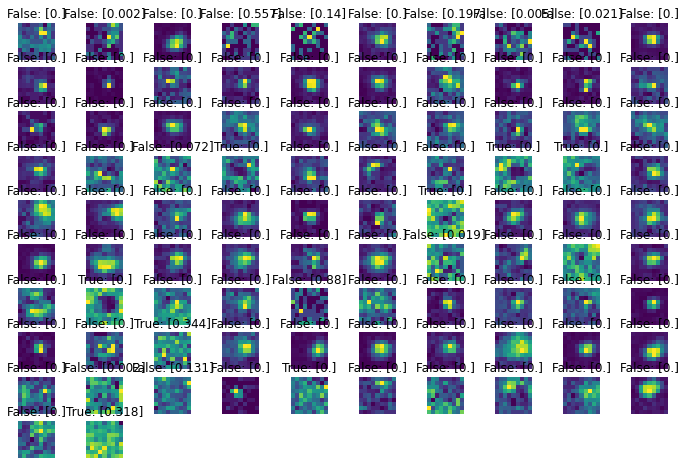

In [698]:
fig, axes = plt.subplots(int(len(area_rfs)/10)+1, 10)
fig.set_size_inches(12, 8)
for irf, (rf, inv, pval) in enumerate(zip(area_rfs, rf_stats['inverted'], rf_stats['pval'])):
    ax_row = int(irf/10)
    ax_col = irf%10
    axes[ax_row][ax_col].imshow(rf, origin='lower')
    axes[ax_row][ax_col].set_title(f'{inv}: {pval}')
                         
for ax in axes.flat:
    ax.axis('off')

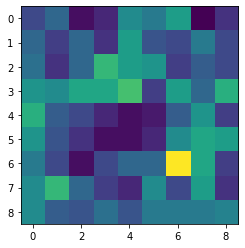

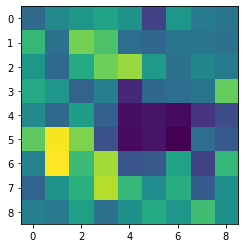

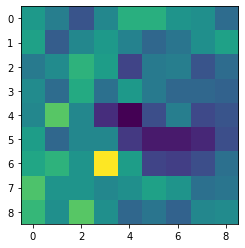

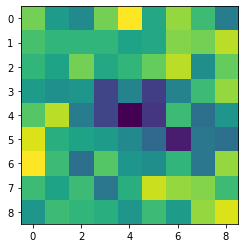

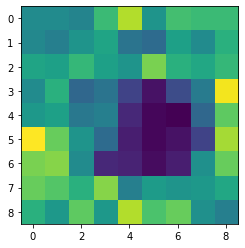

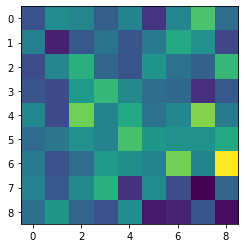

In [699]:
for iu, urf in enumerate(area_rfs):
    stats = rf_stats.iloc[iu]
    if stats['inverted'] and stats['pval']<0.01:
        plt.figure()
        plt.imshow(urf)

#### Now we can merge our receptive field stats into the units dataframe. This will make it easy to run subsequent analysis that might require units to meet RF criteria

In [527]:
units_with_rfstats = units.merge(rf_stats, left_index=True, right_on='unit_id')

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

## Plotting visual responses to novel and familiar images

Image novelty depends on whether a mouse has previously encountered an image during training. Even in the novel image set, 2 images are shared with the training set and therefore familiar. Moreover, some mice train with different image sets, meaning which images are novel depends on all these factors. This can be tricky to sort out, so we have provided a convenient function that will add columns to the stimulus presentations table that indicate which image set a particular image is from (unique to `G`, unique to `H` or shared across both image sets), along with whether it was novel to the mouse during that session.

</div>

In [700]:
session_id = session.metadata['ecephys_session_id']
is_novel_image_set = ecephys_sessions_table.loc[session_id]['experience_level'] == 'Novel'

IMAGE_SET_KEY={
                'G' : ['im012_r', 'im036_r', 'im044_r', 
                    'im047_r', 'im078_r', 'im115_r'],
                'H' : ['im005_r', 'im024_r', 'im034_r', 
                    'im087_r', 'im104_r', 'im114_r'],
                'shared' : ['im083_r', 'im111_r'],
                'omitted' : 'omitted'
                }

In [701]:
def getImageNovelty(image_name):
    '''
    Function to help annotate the stimulus_presentations table
    to indicate the following info:
        1) whether a given image was:
            a) unique to the G set
            b) unique to the H set
            c) shared across G and H
            d) omitted
        2) whether the image was novel to the mouse
    
    Meant to be run on the image names of the stimulus_presentations table
    
    OUTPUT:
        Tuple indicating (image_set, image_novelty) for one 
        row of the stimulus_presentations table

    '''
    # First check that this image is one of the Natural Images used
    image_in_image_set = any([np.isin(image_name, imset) \
                              for _,imset in IMAGE_SET_KEY.items()]) 
    if not image_in_image_set:
        return np.nan, np.nan

    #Get the image set for this image
    image_set_for_this_image = [name for name, image_set in IMAGE_SET_KEY.items()\
                                if image_name in image_set][0]
    
    #Get the image novelty for this image
    if image_set_for_this_image == 'omitted':
        novelty_for_this_image = np.nan
    else:
        novelty_for_this_image = (is_novel_image_set) and \
                            (np.isin(image_set_for_this_image, ['G', 'H']))
    
    return image_set_for_this_image, novelty_for_this_image

Now let's apply that function to our stimulus_presentations table and add the new columns indicating image novelty

In [702]:
image_info = stimulus_presentations.apply(lambda row: getImageNovelty(row['image_name']), axis=1)  
stimulus_presentations['image_set'] = [i[0] for i in image_info]
stimulus_presentations['is_novel'] = [i[1] for i in image_info]

In [703]:
stimulus_presentations[120:130][['image_set', 'is_novel', 'image_name']]

,image_set,is_novel,image_name
stimulus_presentations_id,,,
120,shared,False,im083_r
121,shared,False,im083_r
122,shared,False,im083_r
123,shared,False,im083_r
124,shared,False,im083_r
125,shared,False,im083_r
126,shared,False,im083_r
127,shared,False,im083_r
128,shared,False,im083_r


Now let's use these new columns to look at how image novelty impacts visual responses in VISp.

In [704]:
task_stim_table = stimulus_presentations[stimulus_presentations['active']]

time_before_flash = 1.0
trial_duration = 2.0
bin_size = 0.001
flash_stim_tensor = make_neuron_time_trials_tensor(area_units, task_stim_table, time_before_flash, trial_duration)

In [706]:
# task_stim_table = stimulus_presentations[stimulus_presentations['active']]
# neuron_number = len(area_units)
# trial_time = 0.75
# trial_number = len(task_stim_table)
# time_before_flash = 0.25
# bin_size = 0.001
# unit_tensor = np.zeros((neuron_number, int(1000*trial_time), trial_number))
# for u_counter, (iu, unit) in enumerate(area_units.iterrows()):
#     u_id.append(iu)
#     unit_spike_times = spike_times[iu]
#     for t_counter, (it, trial) in enumerate(task_stim_table.iterrows()):
#         trial_start = trial.start_time - time_before_flash
#         unit_tensor[u_counter, :, t_counter] = makePSTH(unit_spike_times, 
#                                                         [trial_start], 
#                                                         trial_time, 
#                                                         binSize=bin_size)[0]

In [738]:
unit_da = xr.DataArray(flash_stim_tensor, dims=("unit_id", "time", "trials"), 
                       coords={
                           "unit_id": area_units.index.values,
                           "time": np.arange(0, trial_duration, bin_size)-time_before_flash,
                           "trials": task_stim_table.index.values
                           })

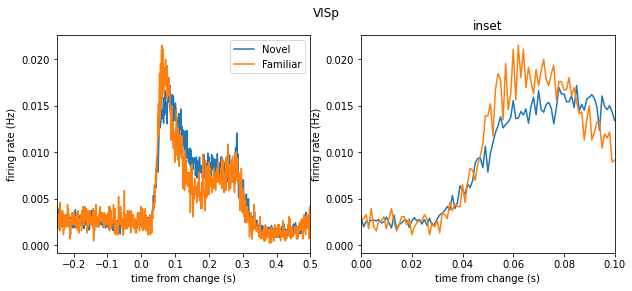

In [739]:
fig, axes = plt.subplots(1,2)
fig.set_size_inches([10, 4])
fig.suptitle(area_of_interest)
for isnovel in [True, False]:
    trial_ids = task_stim_table[(task_stim_table['is_change'])&(task_stim_table['is_novel']==isnovel)].index.values
    relevant_trials = unit_da.sel(trials=trial_ids)
    mean_over_trials = relevant_trials.mean(dim=['unit_id', 'trials'])
    [ax.plot(unit_da.time, mean_over_trials) for ax in axes]

xlims = ([-0.25, 0.5], [0, 0.1])
for ax, xlim in zip(axes, xlims):
    ax.set_xlabel('time from change (s)')
    ax.set_ylabel('firing rate (Hz)')
    ax.set_xlim(xlim)
axes[1].set_title('inset')
axes[0].legend(['Novel', 'Familiar'])

In [716]:
time_before_change = 1
duration = 2.5
cr_dict = {'novel':[], 'familiar':[]}
shared_ims = ['im083_r', 'im111_r']
for iu, unit in area_units.iterrows():
    unit_spike_times = spike_times[iu]
    for condition in ['novel', 'familiar']:
        if condition=='novel':
            novel_filter = ~task_stim_table['image_name'].isin(shared_ims)
        else:
            novel_filter = task_stim_table['image_name'].isin(shared_ims)
        change_times = task_stim_table[novel_filter & task_stim_table['is_change']]['start_time'].values
        unit_change_response, bins = makePSTH(unit_spike_times, 
                                          change_times-time_before_change, 
                                          duration, binSize=0.01)
        cr_dict[condition].append(unit_change_response)

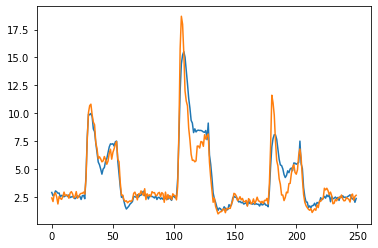

In [721]:
plt.figure()
plt.plot(np.mean(cr_dict['novel'], axis=0))
plt.plot(np.mean(cr_dict['familiar'], axis=0))


# How does novelty impact mouse behavior?

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

## Understanding the trials table
    
    
</div>

Let's briefly review the timing of the change detection task (`stimulus_block` 0 or the `active` portion of the stimulus table). Remember the mouse is rewarded for licking to changes in the identity of a flashing natural image. 

* Each flash is 250 ms long with 500 ms of gray screen between images (ie, 750 ms from the start of flash *n* to the start of flash *n+1*). 

* Mice are rewarded for licking within a reward window defined as 150-750 ms after an image change. 

* Licks before the change abort the trial, and a new trial begins

* 5% of flashes can be omitted with the exception of 1) the flash immediately following an omission and 2) the flash immediately preceding a change which can't be omitted.



<img src="resources/task_diagram.png"/>
     

Now let's explore the behavior trials table. This table contains lots of useful information about every trial in the change detection task.

In [709]:
trials = session.trials
trials.head()

,start_time,stop_time,initial_image_name,change_image_name,stimulus_change,change_time_no_display_delay,go,catch,lick_times,response_time,reward_time,reward_volume,hit,false_alarm,miss,correct_reject,aborted,auto_rewarded,change_frame,trial_length
trials_id,,,,,,,,,,,,,,,,,,,,
0,26.47193,27.45562,im104_r,im104_r,False,NaN,False,False,"[26.97173, 27.13853]",NaN,NaN,0.000,False,False,False,False,True,False,NaN,0.98369
1,27.97281,35.24574,im104_r,im024_r,True,30.97555,False,False,"[31.80908, 31.90917, 31.992300000000004, 32.10...",31.80908,31.12617,0.005,False,False,False,False,False,True,330.0,7.27293
2,35.47899,37.28095,im024_r,im024_r,False,NaN,False,False,"[36.73014, 36.96305]",NaN,NaN,0.000,False,False,False,False,True,False,NaN,1.80196
3,37.73082,39.51563,im024_r,im024_r,False,NaN,False,False,"[39.01525, 39.19819, 39.79894]",NaN,NaN,0.000,False,False,False,False,True,False,NaN,1.78481
4,39.98268,43.11863,im024_r,im024_r,False,NaN,False,False,"[42.63507, 42.81821, 43.35172, 43.58527]",NaN,NaN,0.000,False,False,False,False,True,False,NaN,3.13595


Unlike the stimulus presentations table in which every row corresponded to a visual stimulus presentation, for the behavior trials table every row corresponds to one trial of the change detection task. Here is a quick summary of the columns:

`start_time`: Experiment time when this trial began in seconds.

`stop_time`: Experiment time when this trial ended.

`initial_image_name`: Indicates which image was shown before the change (or sham change) for this trial

`change_image_name`: Indicates which image was scheduled to be the change image for this trial. Note that if the trial is aborted, a new trial will begin before this change occurs.

`stimulus_change`: Indicates whether an image change occurred for this trial. 

`change_time_no_display_delay`: Experiment time when the task-control computer commanded an image change. This change time is used to determine the response window during which a lick will trigger a reward. Note that due to display lag, this is not the time when the change image actually appears on the screen. To get this time, you need the stimulus_presentations table (more about this below).

`go`: Indicates whether this trial was a 'go' trial. To qualify as a go trial, an image change must occur and the trial cannot be autorewarded.

`catch`: Indicates whether this trial was a 'catch' trial. To qualify as a catch trial, a 'sham' change must occur during which the image identity does not change. These sham changes are drawn to match the timing distribution of real changes and can be used to calculate the false alarm rate.

`lick_times`: A list indicating when the behavioral control software recognized a lick. Note that this is not identical to the lick times from the licks dataframe, which record when the licks were registered by the lick sensor. The licks dataframe should generally be used for analysis of the licking behavior rather than these times.

`response_time`: Indicates the time when the first lick was registered by the task control software for trials that were not aborted (go or catch). NaN for aborted trials. For a more accurate measure of response time, the licks dataframe should be used.

`reward_time`: Indicates when the reward command was triggered for hit trials. NaN for other trial types. 

`reward_volume`: Indicates the volume of water dispensed as reward for this trial. 

`hit`: Indicates whether this trial was a 'hit' trial. To qualify as a hit, the trial must be a go trial during which the stimulus changed and the mouse licked within the reward window (150-750 ms after the change time).

`false_alarm`: Indicates whether this trial was a 'false alarm' trial. To qualify as a false alarm, the trial must be a catch trial during which a sham change occurred and the mouse licked during the reward window.

`miss`: To qualify as a miss trial, the trial must be a go trial during which the stimulus changed but the mouse did not lick within the response window.

`correct_reject`: To qualify as a correct reject trial, the trial must be a catch trial during which a sham change occurred and the mouse withheld licking.

`aborted`: A trial is aborted when the mouse licks before the scheduled change or sham change.

`auto_rewarded`: During autorewarded trials, the reward is automatically triggered after the change regardless of whether the mouse licked within the response window. These always come at the beginning of the session to help engage the mouse in behavior.

`change_frame`: Indicates the stimulus frame index when the change (on go trials) or sham change (on catch trials) occurred. This column can be used to link the trials table with the stimulus presentations table.

`trial_length`: Duration of the trial in seconds.

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

## Calculating hit rates for novel and familiar images
    
</div>

Let's use the trials table to calculate the hit rates for the novel and familiar images:. First, let's take each image and calculate the hit rate for trials in which that image was the change image.

In [710]:
#First, let's annotate the trials by the novelty of their change image using the function we wrote above
image_info = trials.apply(lambda row: getImageNovelty(row['change_image_name']), axis=1)
trials['change_image_set'] = [i[0] for i in image_info]
trials['is_novel_change_image'] = [bool(i[1]) for i in image_info]

In [711]:
#let's grab the go trials since those are the ones we'll need to calculate hit rates
go_trials = trials[trials['go']]

#Now we can use a pivot table to calculate the image-wise hit rates
image_hit_rates = go_trials.pivot_table(index='change_image_name', values=['hit', 'is_novel_change_image'], 
                                        aggfunc={'hit':['mean', 'count'], 'is_novel_change_image':'first'})

#Give the columns more convenient/descriptive names
image_hit_rates.columns = image_hit_rates.columns.to_flat_index()
image_hit_rates = image_hit_rates.rename(columns={('hit', 'count'):'num_trials', 
                                ('hit', 'mean'):'hit_rate',
                                ('is_novel_change_image', 'first'): 'is_novel'})

display(image_hit_rates.style.background_gradient())

,num_trials,hit_rate,is_novel
change_image_name,,,
im005_r,27,0.333333,True
im024_r,26,0.346154,True
im034_r,26,0.461538,True
im083_r,26,0.346154,False
im087_r,24,0.416667,True
im104_r,25,0.360000,True
im111_r,23,0.478261,False
im114_r,25,0.400000,True


In [712]:
def get_binom_ci(successes, total, proportion):    
    result = binomtest(int(successes), 
                       n=int(total), 
                       p=proportion)
    ci = result.proportion_ci(confidence_level=0.95)
    return [np.round(c,2) for c in ci]

cis = image_hit_rates.apply(lambda row: get_binom_ci(row['num_trials']*row['hit_rate'],
                                              row['num_trials'],
                                              row['hit_rate']), axis=1)

image_hit_rates['confidence_interval'] = cis
image_hit_rates

,num_trials,hit_rate,is_novel,confidence_interval
change_image_name,,,,
im005_r,27,0.333333,True,"[0.17, 0.54]"
im024_r,26,0.346154,True,"[0.17, 0.56]"
im034_r,26,0.461538,True,"[0.27, 0.67]"
im083_r,26,0.346154,False,"[0.17, 0.56]"
im087_r,24,0.416667,True,"[0.22, 0.63]"
im104_r,25,0.360000,True,"[0.18, 0.57]"
im111_r,23,0.478261,False,"[0.27, 0.69]"
im114_r,25,0.400000,True,"[0.21, 0.61]"


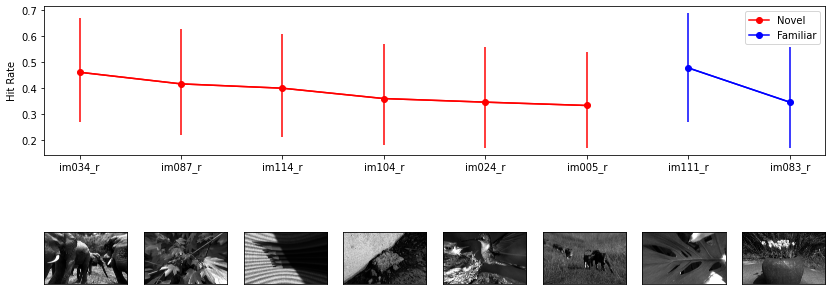

In [713]:
from matplotlib.gridspec import GridSpec
from scipy.stats import binomtest

fig = plt.figure()
fig.set_size_inches(14, 6)
gs = GridSpec(2, 8, figure=fig)
hit_rate_ax = fig.add_subplot(gs[0, :])
colors = ['r', 'b']
image_order = []
for isnovel, color in zip([True, False], colors):
    rows = image_hit_rates[image_hit_rates['is_novel']==isnovel]
    rows = rows.sort_values('hit_rate', ascending=False)
    
    hit_rates = rows['hit_rate']
    hit_rate_ax.plot(hit_rates, color+'o-')
    errorbars = np.abs(np.vstack(rows.confidence_interval).T - hit_rates.values[None, :])
    
    hit_rate_ax.errorbar(np.arange(len(image_order), len(image_order) + len(hit_rates)), 
                         hit_rates, 
                        yerr=errorbars,
                        color=color)
    
    image_order.extend(rows.index.values)
    
hit_rate_ax.set_ylabel('Hit Rate')
hit_rate_ax.legend(['Novel', 'Familiar'])

    
for ind, im in enumerate(image_order):
    im_ax = fig.add_subplot(gs[1, ind])
    im_ax.imshow(session.stimulus_templates['warped'][im], cmap='gray')
    im_ax.axes.xaxis.set_visible(False)
    im_ax.axes.yaxis.set_visible(False)


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

## Getting pupil, running and licking data
    
</div>

In [ ]:
#quick intro to the pupil, running and licking dataframes

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

## Aligning behavioral data to task events
    
</div>

In [40]:
#Align pupil, running, licking to novel vs familiar changes? or something simpler...
#We could just introduce the dataframes and then leave analysis for exercises.

### exercise ideas:

(still need to think of some easier ones; these are all the same-ish difficulty)

1: compare responses during active and passive epochs across brain regions. Which are most modulated?

2: compare responses of different cell types (SST, RS, FS) defined by optotagging and waveform features

3: compare rate of adaptation to repeated flashes of same stimulus across areas

?